Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


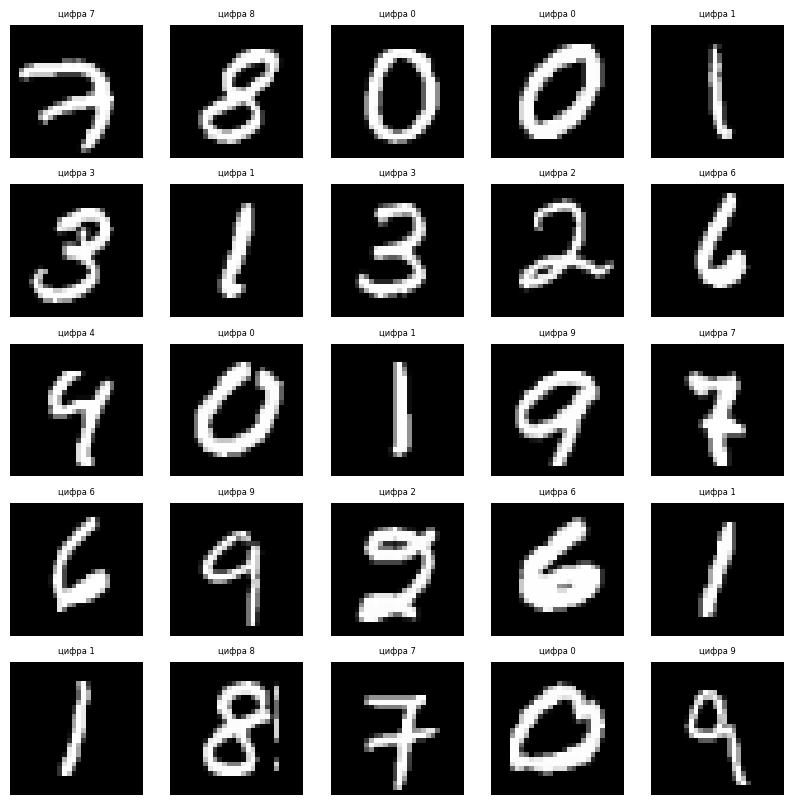

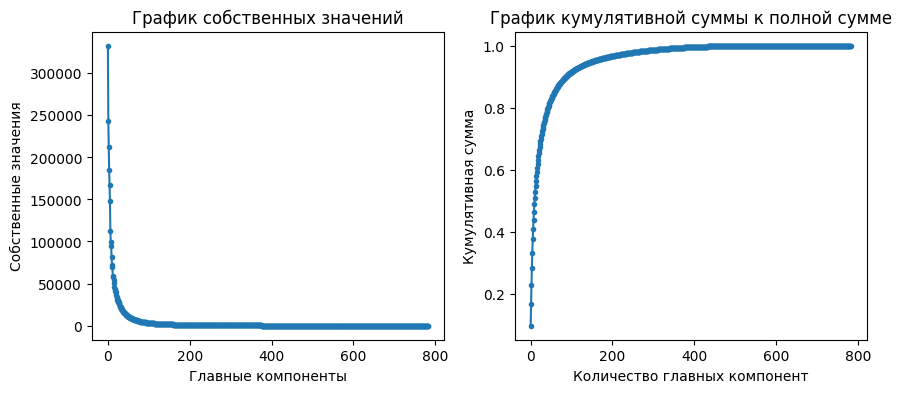

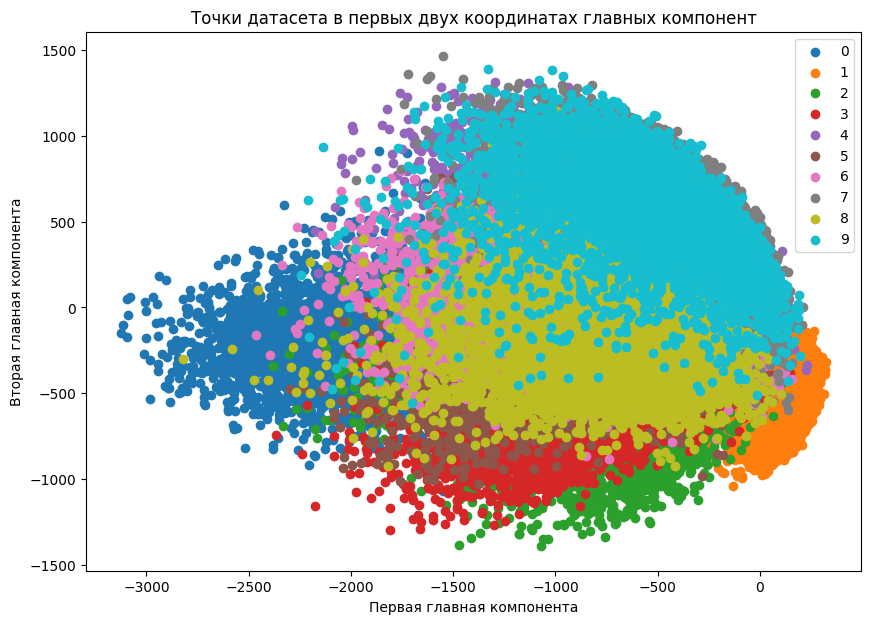

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from mnist import load_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

train, validation, test = load_mnist()

X_tr = train[0].reshape(55000, -1)
Y_tr = train[1]

fig, axs = plt.subplots(5, 5, figsize=(10,10))
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(train[0][i+5*j], cmap='gray')
        axs[i,j].set_title(f'цифра {train[1][i+5*j]}', fontsize=6)
        axs[i,j].axis('off')

class my_PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.eigenvalues = None

    def fit(self, X):
        mean = np.mean(X, axis=0)
        X_centered = X - mean
        cov_matrix = np.cov(X_centered, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

        sort_down = np.argsort(eigenvalues)[::-1]
        self.eigenvalues = eigenvalues[sort_down]
        eigenvectors = eigenvectors[:, sort_down]
        self.components = eigenvectors[:, :self.n_components]

    def transform(self, X):
        return np.dot(X, self.components)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

pca = my_PCA(n_components=2)
X_pca = pca.fit_transform(X_tr)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(pca.eigenvalues, marker='.')
plt.xlabel('Главные компоненты')
plt.ylabel('Собственные значения')
plt.title('График собственных значений')

cumulative_sum = np.cumsum(pca.eigenvalues) / np.sum(pca.eigenvalues)

plt.subplot(1, 2, 2)
plt.plot(cumulative_sum, marker='.', linestyle='-')
plt.xlabel('Количество главных компонент')
plt.ylabel('Кумулятивная сумма')
plt.title('График кумулятивной суммы к полной сумме')

plt.figure(figsize=(10, 7))
for i in range(10):
    plt.scatter(X_pca[Y_tr == i, 0], X_pca[Y_tr == i, 1], label=str(i))
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('Точки датасета в первых двух координатах главных компонент')
plt.legend()
plt.show()

class my_kNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_tr = None
        self.Y_tr = None

    def fit(self, X, y):
        self.X_tr = X
        self.Y_tr = y

    def predict(self, X):
        preds = []
        for x in X:
            dist = np.linalg.norm(self.X_tr - x, axis=1)
            index = np.argsort(dist)[:self.n_neighbors]
            label = self.Y_tr[index]
            pred = np.bincount(label).argmax()
            preds.append(pred)
        return np.array(preds)

X_tr, X_test, y_tr, y_test = train_test_split(X_pca, Y_tr, test_size=0.2, random_state=42)

knn = my_kNN(n_neighbors=5)
knn.fit(X_tr, y_tr)

y_pred = knn.predict(X_test)

accuracy_score(y_test, y_pred)

best_accuracy = 0
best_n_neighbors = 0
best_n_components = 0
pca = my_PCA(n_components=50)
X_tr_pca = pca.fit_transform(X_tr)
X_test_pca = pca.transform(X_test)
accuracies = []

for n_neighbors in range(1, 31, 5):
    n_accuracies = []
    for n_components in range(1, 51, 10):
        knn = my_kNN(n_neighbors=n_neighbors)
        knn.fit(X_tr_pca[:, :n_components], y_tr)
        y_pred = knn.predict(X_test_pca[:, :n_components])
        accuracy = accuracy_score(y_test[:1000], y_pred[:1000])
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_neighbors = n_neighbors
            best_n_components = n_components
        n_accuracies.append(accuracy)
    accuracies.append(n_accuracies)
    plt.plot(range(1, 51, 10), n_accuracies, label=f'n_neighbors={n_neighbors}')

plt.xlabel('Количество главных компонент')
plt.ylabel('Точность')
plt.title('Графики зависимости доли правильных ответов в зависимости от количества главных компонент для нескольких значений числа соседей')
plt.legend()
plt.show()
print('Наилучшая точность:', best_accuracy) 
print('Наилучшее количество соседей:', best_n_neighbors)
